In [1]:
import numpy as np

In [2]:

def matmul(A,B):
  result=[[0 for i in range(B.shape[1])] for j in range(A.shape[0])]
  for i in range(len(A)):
    for j in range(len(B[0])):
        for k in range(len(B)):
          result[i][j] += A[i][k] * B[k][j]
  return np.array(result)

  


In [3]:
class mult:
  def __init__(self):
    filename = "/content/factorizations_r.npz"
    with open(filename, 'rb') as f:
      self.factorizations = dict(np.load(f, allow_pickle=True))
  def check(self,tup):
    far=None
    for v in self.factorizations:
      ar=list(map(int,v.split(",")))
      if tup[0]%ar[0]==0 and tup[1]%ar[1]==0 and tup[2]%ar[2]==0 and tup[0]//ar[0]==tup[1]//ar[1] and tup[0]//ar[0]==tup[2]//ar[2]:
        far=ar
    if far!=None:
      return True,far
    return False,None
  def comb(self,a):
    res=[]
    for i in range(a.shape[0]):
      ar=np.array(a[i][0])
      for j in range(1,a.shape[1]):
        ar=np.concatenate((ar,a[i][j]),axis=1)
      res.append(ar)
    nar=res[0]
    for i in range(1,len(res)):
      nar=np.concatenate((nar,res[i]),axis=0)
    return nar
  def crop(self,a,n):
    # print("cs",a.shape,"n",n)
    i=0
    j=0
    res=[[None for k in range(a.shape[1]//n)] for g in range(a.shape[0]//n)]
    x=0
    y=0
  # print(len(res),len(res[0]))
  #print(x,y,res[0][0],a.shape)
    while(i<a.shape[0]):
    # print(i,j,x,y)
       while(j<a.shape[1]):
         res[x][y]=a[i:i+n,j:j+n]
         j+=n
         y+=1
       x+=1
       i+=n
       j=0
       y=0
    
    return np.array(res)    
  def aft(self,a,b,seq,f) :
    "Code to multiply matrix based on factors"
    # print("aftseq",seq,a.shape,b.shape)
    n=a.shape[0]//seq[0]
    val=str(seq[0])+","+str(seq[1])+","+str(seq[2])
    factors=self.factorizations[val]
    factors = [factors[0], factors[1], factors[2]]
    rank = factors[0].shape[-1]
    factors[2] = np.reshape(factors[2],(seq[2], seq[0], rank))
    factors[2] = factors[2].transpose(1, 0, 2).reshape(seq[2]*seq[0],rank)
    a=self.crop(a,n)
    b=self.crop(b,n)
    
    a=np.reshape(a,(a.shape[0]*a.shape[1],n,n))
    b=np.reshape(b,(b.shape[0]*b.shape[1],n,n))

    # st=time.time()
    left=np.einsum('iR,i...->R...', factors[0], a)
    right=np.einsum('iR,i...->R...', factors[1], b)
    mp=np.einsum('R...,R...->R...', left, right)
    mp=np.array([f(left[i],right[i] )for i in range(len(left))])
    res=np.einsum('iR,R...->i...', factors[2], mp)
    # en=time.time()
    res=np.reshape(res,(seq[0],seq[2],n,n))
    # print(en-st)
    # print(res.shape)
    return self.comb(res)
    
    
  
  

In [4]:
# Base class
class Layer:
    def __init__(self):
        self.input = None
        self.output = None
        self.want=None

    # computes the output Y of a layer for a given input X
    def forward_propagation(self, input):
        raise NotImplementedError

    # computes dE/dX for a given dE/dY (and update parameters if any)
    def backward_propagation(self, output_error, learning_rate):
        raise NotImplementedError

In [5]:
mul=mult()

In [6]:
# from layer import Layer
import numpy as np

# inherit from base class Layer
class FCLayer(Layer):
    # input_size = number of input neurons
    # output_size = number of output neurons
    def __init__(self, m,input_size,output_size,mult,func,want,seed=42):
        np.random.seed(seed)
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(m, output_size) - 0.5
        self.mul=mult
        self.want=want
        self.f=func
    # returns output for a given input
    def forward_propagation(self, input_data):
        self.input = input_data
        val,seq=self.mul.check([self.input.shape[0],self.input.shape[1],self.weights.shape[1]])
        # print("fp",seq)
        # print("val",val,self.want)
        if self.want and val:
          self.output = self.mul.aft(self.input, self.weights,seq,self.f) + self.bias
        else:
          self.output = self.f(self.input, self.weights) + self.bias
        # print("id",input_data.shape,"ws",self.weights.shape,"bs",self.bias.shape)
        return self.output

    # computes dE/dW, dE/dB for a given output_error=dE/dY. Returns input_error=dE/dX.
    def backward_propagation(self, output_error, learning_rate):
        val,seq=self.mul.check([output_error.shape[0],output_error.shape[1],self.weights.shape[0]])
        # print("bp",seq)
        # print("val",val,"want",self.want)
        if self.want and val:
          input_error = self.mul.aft(output_error, self.weights.T,seq,self.f)
        else:
          input_error = self.f(output_error, self.weights.T)
        val,seq=self.mul.check([self.input.shape[1],self.input.shape[0],output_error.shape[1]])
        if self.want and val:
          weights_error = self.mul.aft(self.input.T, output_error,seq,self.f)
        else:
          weights_error = self.f(self.input.T, output_error)
        # dBias = output_error

        # update parameters
        # print("weshape",weights_error.shape,"outerror",output_error.shape,"ieshape",input_error.shape)
    
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error

        return input_error

In [7]:
# from layer import Layer

# inherit from base class Layer
class ActivationLayer(Layer):
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # returns the activated input
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    # Returns input_error=dE/dX for a given output_error=dE/dY.
    # learning_rate is not used because there is no "learnable" parameters.
    def backward_propagation(self, output_error, learning_rate):
        val=self.activation_prime(self.input) * output_error
        # print("as",val.shape,self.activation_prime(self.input).shape,output_error.shape)
        return val

In [8]:

import numpy as np

# activation function and its derivative
def tanh(x):
    return np.tanh(x);

def tanh_prime(x):
    return 1-np.tanh(x)**2;

In [9]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size

In [10]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = None
        self.loss_prime = None
     
    # add layer to network
    def add(self, layer):
        self.layers.append(layer)

    # set loss to use
    def use(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    # predict output for given input
    def predict(self, input_data):
        # sample dimension first
        samples = len(input_data)
        result = []

        # run network over all samples
        for i in range(samples):
            # forward propagation
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)

        return result

    # train the network
    def fit(self, x_train, y_train, epochs, learning_rate):
        # sample dimension first
        samples = len(x_train)
        
        # training loop
        for i in range(epochs):
            err = 0
            for j in range(samples):
                # forward propagation
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)

                # compute loss (for display purpose only)
                err += self.loss(y_train[j], output)
                # print("er",err,y_train[j],output)
                # backward propagation
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backward_propagation(error, learning_rate)

            # calculate average error on all samples
            err /= samples
            print('epoch %d/%d   error=%f' % (i+1, epochs, err))

In [11]:
n=13*4
ld=2

In [12]:
from keras.datasets import mnist
from keras.utils import np_utils
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# training data : 60000 samples
# reshape and normalize input data

x_train=x_train[:ld*n]
y_train=y_train[:ld*n]
x_train = x_train.reshape(ld, n, 28*28)
x_train = x_train.astype('float32')
x_train /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

y_train = np_utils.to_categorical(y_train)
y_train=y_train.reshape(ld,n,10)

x_test=x_test[:(ld)*n]
y_test=y_test[:(ld)*n]
x_test = x_test.reshape(ld, n, 28*28)
x_test = x_test.astype('float32')
x_test /= 255
# encode output which is a number in range [0,9] into a vector of size 10
# e.g. number 3 will become [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
y_test = np_utils.to_categorical(y_test)
y_test=y_test.reshape(ld,n,10)

In [13]:
y_train.shape

(2, 52, 10)

In [25]:
import time
trials=10

In [26]:
import matplotlib.pyplot as plt

In [27]:
want=0

In [28]:
tr2=np.array([i for i in range(trials)])
tm2=[]

In [29]:
for i in range(trials):
  print("TRIAL NO-----",i+1)
  net = Network()
  net.add(FCLayer(n, 28*28,13*5,mul,matmul,want))
  net.add(ActivationLayer(tanh, tanh_prime))
  for i in range(3):
    net.add(FCLayer(n,13*5, 13*5,mul,matmul,want))
    net.add(ActivationLayer(tanh, tanh_prime))
# net.add(FCLayer(4,5, 5,mul,1))
# net.add(ActivationLayer(tanh, tanh_prime))
# net.add(FCLayer(4,5, 5,mul,1))
# net.add(ActivationLayer(tanh, tanh_prime))
# net.add(FCLayer(4,5, 5,mul,1))
# net.add(ActivationLayer(tanh, tanh_prime))
  net.add(FCLayer(n,13*5, 10,mul,matmul,want))
  net.add(ActivationLayer(tanh, tanh_prime))

  net.use(mse, mse_prime)
  st=time.time()
  net.fit(x_train, y_train, epochs=2, learning_rate=0.1)
  et=time.time()
  tm2.append(et-st)
  
tm2=np.array(tm2)



TRIAL NO----- 1
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 2
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 3
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 4
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 5
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 6
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 7
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 8
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 9
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977
TRIAL NO----- 10
epoch 1/2   error=0.727756
epoch 2/2   error=0.671977


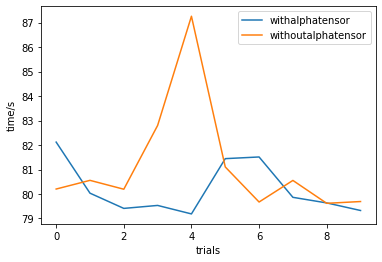

In [33]:
plt.plot(tr,tm[:])
plt.plot(tr,tm2[:])
plt.legend(["withalphatensor", "withoutalphatensor"], loc ="upper right")
plt.xlabel("trials")
plt.ylabel("time/s")
plt.show()


In [ ]:
print(np.mean(tm[1:]))

41.283435344696045


In [20]:
tm

array([82.11867833, 80.03319979, 79.41114879, 79.53239226, 79.1857996 ,
       81.44342875, 81.51177096, 79.86340451, 79.63502455, 79.32558298])

In [30]:
tm2

array([80.2021327 , 80.556844  , 80.1943953 , 82.79880786, 87.25987172,
       81.10428095, 79.67200446, 80.5533874 , 79.6186657 , 79.6915648 ])

In [31]:
tm

array([82.11867833, 80.03319979, 79.41114879, 79.53239226, 79.1857996 ,
       81.44342875, 81.51177096, 79.86340451, 79.63502455, 79.32558298])